In [1]:
# import pandas as pd
# import numpy as np
# import spacy
# import nltk
# from nltk import pos_tag
# from nltk.tokenize import word_tokenize
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from rake_nltk import Rake
# import matplotlib.pyplot as plt
# import re
# import string

# # Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# # Initialize VADER and RAKE
# analyzer = SentimentIntensityAnalyzer()
# rake = Rake()

In [2]:
# def clean_text(text):
#     text = text.translate(str.maketrans('', '', string.punctuation))
#     text = re.sub(r'\s+', ' ', text).strip()
#     text = text.lower()
#     return text

In [3]:
# def perform_ner(texts):
#     all_entities = []
#     for text in texts:
#         doc = nlp(text)
#         entities = [(ent.text, ent.label_) for ent in doc.ents]
#         all_entities.extend(entities)
#     return all_entities

In [4]:
# def get_pos_tags(texts):
#     all_tags = []
#     for text in texts:
#         tokens = word_tokenize(text)
#         tags = pos_tag(tokens)
#         all_tags.extend(tags)
#     return all_tags

In [5]:
# def top_nouns_verbs_adjectives(tags, top_n=10):
#     nouns = [word for word, pos in tags if pos in ['NN', 'NNS', 'NNP', 'NNPS']]
#     verbs = [word for word, pos in tags if pos.startswith('VB')]
#     adjectives = [word for word, pos in tags if pos in ['JJ', 'JJR', 'JJS']]
    
#     return {
#         'nouns': nltk.FreqDist(nouns).most_common(top_n),
#         'verbs': nltk.FreqDist(verbs).most_common(top_n),
#         'adjectives': nltk.FreqDist(adjectives).most_common(top_n)
#     }


In [6]:
# def detect_emotions(texts):
#     all_scores = []
#     for text in texts:
#         sentiment = analyzer.polarity_scores(text)
#         all_scores.append(sentiment['compound'])
#     return all_scores

In [7]:
# # Can update this functionality to generate keywords based on specific topics or related word meanings
# def extract_keywords(texts):
#     all_keywords = []
#     for text in texts:
#         rake.extract_keywords_from_text(text)
#         keywords = rake.get_ranked_phrases()
#         all_keywords.extend(keywords)
#     return all_keywords

In [8]:
# def analyze_sentiment_scores(scores):
#     mean_score = np.mean(scores)
#     return mean_score

In [9]:
# def plot_sentiment_distribution(scores):
#     plt.figure(figsize=(10, 6))
#     plt.hist(scores, bins=20, edgecolor='black')
#     plt.title('Sentiment Score Distribution')
#     plt.xlabel('Sentiment Score')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

In [10]:
# def average_word_count(texts):
#     word_counts = [len(text.split()) for text in texts]
#     return np.mean(word_counts)

In [11]:
# def import_and_process_data(file_path):
#     df = pd.read_excel(file_path, header=None, names=['review'])
#     reviews = df['review'].tolist()
    
#     # Clean the entire list of reviews
#     cleaned_reviews = [clean_text(review) for review in reviews]
    
#     # NER
#     entities = perform_ner(cleaned_reviews)
    
#     # POS Tagging
#     pos_tags = get_pos_tags(cleaned_reviews)
#     top_pos_tags = top_nouns_verbs_adjectives(pos_tags)
    
#     # Emotion Detection
#     sentiment_scores = detect_emotions(cleaned_reviews)
    
#     # Keyword Extraction
#     keywords = extract_keywords(cleaned_reviews)
    
#     # Compute statistics
#     avg_sentiment_score = analyze_sentiment_scores(sentiment_scores)
#     avg_word_count = average_word_count(reviews)
#     print(f"Average Sentiment Score: {avg_sentiment_score}")
#     print(f"Average Word Count per Review: {avg_word_count}")
    
#     # NER
#     print("\nNER:")
#     print(set(entities))  # Print unique entities

#     # POS
#     print("\nTop POS Tags:")
#     print('Nouns:')
#     print(top_pos_tags['nouns'])
#     print('Verbs:')
#     print(top_pos_tags['verbs'])
#     print('Adj:')
#     print(top_pos_tags['adjectives'])

#     # Keyword extraction
#     print("\nKeywords Extracted:")
#     print(set(keywords))  # Print unique keywords
    
#     # Plot sentiment distribution
#     plot_sentiment_distribution(sentiment_scores)

# # Define the file path
# file_path = 'sentiment_data/73.xlsx'

# import_and_process_data(file_path)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import io

# Define your hyperparameters
block_size = 256
n_embd = 768
n_head = 12
n_layer = 2
dropout = 0.4
output_size = 2

# Load vocabulary
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        for line in f:
            yield [line.split("\t")[0]]

vocab = build_vocab_from_iterator(yield_tokens("sentencepiece/transformer.vocab"), 
                                  specials=['<cls>', '<pad>', '<eos>', '<unk>'], 
                                  special_first=True)
vocab.set_default_index(vocab['<unk>'])

# Define text transform
text_transform = T.Sequential(
    T.SentencePieceTokenizer("sentencepiece/transformer.model"),
    T.VocabTransform(vocab),
    T.AddToken(vocab['<cls>'], begin=True),
    T.Truncate(max_seq_len=254),
    T.AddToken(vocab['<eos>'], begin=False),
    T.ToTensor(padding_value=vocab['<pad>']),
    T.PadTransform(max_length=256, pad_value=0),
)

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out, wei

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = []
        attn_weights = []
        for h in self.heads:
            head_out, head_attn = h(x)
            out.append(head_out)
            attn_weights.append(head_attn)
        out = torch.cat(out, dim=-1)
        out = self.dropout(self.proj(out))
        attn_weights = torch.stack(attn_weights, dim=1)
        return out, attn_weights

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        sa_out, attn_weights = self.sa(self.ln1(x))
        x = x + sa_out
        x = x + self.ffwd(self.ln2(x))
        return x, attn_weights

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(len(vocab), n_embd)
        self.position_embedding_table = nn.Embedding(block_size + 1, n_embd)
        self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, output_size)
 
    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb

        attn_weights = None
        for i, block in enumerate(self.blocks):
            x, attn_weights = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x[:, 0, :])

        return logits, attn_weights

/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kennykguo/anaconda3/envs/deep-learning/lib/python3.8/site-packages/torchtext/transfor

In [13]:
import torch
import torch.nn.functional as F

def predict_single_text(model, text, text_transform, vocab):
    device = next(model.parameters()).device
    tokens = text_transform([text]).to(device)
    
    with torch.no_grad():
        logits, attn_weights = model(tokens)
    
    probs = F.softmax(logits, dim=-1)
    label = torch.argmax(probs, dim=1)
    
    # Analyze attention weights
    att_map = attn_weights[0, -1, :, :]  # Last head, first sample
    att_weights = att_map[0]  # Attention weights for the [CLS] token
    top10 = att_weights.argsort(descending=True)[:10]
    top10_tokens = [vocab.lookup_token(tokens[0][idx].item()) for idx in top10]
    
    prediction = 'positive' if label.item() == 1 else 'negative'
    return prediction, top10_tokens

def load_model(model_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = Transformer()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

In [14]:
# import pandas as pd
# import torch
# import sys
# import os

# def predict_single_text(model, text, text_transform, vocab):
#     device = next(model.parameters()).device
#     tokens = text_transform([text]).to(device)
    
#     with torch.no_grad():
#         logits, attn_weights = model(tokens)
    
#     probs = torch.nn.functional.softmax(logits, dim=-1)
#     label = torch.argmax(probs, dim=1)
    
#     # Analyze attention weights
#     att_map = attn_weights[0, -1, :, :]  # Last head, first sample
#     att_weights = att_map[0]  # Attention weights for the [CLS] token
#     top10 = att_weights.argsort(descending=True)[:10]
#     top10_tokens = [vocab.lookup_token(tokens[0][idx].item()) for idx in top10]
    
#     prediction = 'positive' if label.item() == 1 else 'negative'
#     return prediction, top10_tokens

# def import_and_process_data(file_path):
#     df = pd.read_excel(file_path, header=None, names=['review'])
#     reviews = df['review'].tolist()
    
#     # Clean the entire list of reviews
#     cleaned_reviews = [clean_text(review) for review in reviews]
    
#     # NER
#     entities = perform_ner(cleaned_reviews)
    
#     # POS Tagging
#     pos_tags = get_pos_tags(cleaned_reviews)
#     top_pos_tags = top_nouns_verbs_adjectives(pos_tags)
    
#     # Emotion Detection
#     sentiment_scores = detect_emotions(cleaned_reviews)
    
#     # Keyword Extraction
#     keywords = extract_keywords(cleaned_reviews)
    
#     # Compute statistics
#     avg_sentiment_score = analyze_sentiment_scores(sentiment_scores)
#     avg_word_count = average_word_count(reviews)
#     print(f"Average Sentiment Score: {avg_sentiment_score}")
#     print(f"Average Word Count per Review: {avg_word_count}")
    
#     # NER
#     print("\nNER:")
#     print(set(entities))  # Print unique entities

#     # POS
#     print("\nTop POS Tags:")
#     print('Nouns:')
#     print(top_pos_tags['nouns'])
#     print('Verbs:')
#     print(top_pos_tags['verbs'])
#     print('Adj:')
#     print(top_pos_tags['adjectives'])

#     # Keyword extraction
#     print("\nKeywords Extracted:")
#     print(set(keywords))  # Print unique keywords
    
#     # Plot sentiment distribution
#     plot_sentiment_distribution(sentiment_scores)

#     # PyTorch Model Inference
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = Transformer()
#     model.load_state_dict(torch.load('model_weights/gpt.pth'))
#     model = model.to(device)
#     model.eval()

#     print("\nPyTorch Model Predictions:")
#     for i, review in enumerate(cleaned_reviews):
#         prediction, top_words = predict_single_text(model, review, text_transform, vocab)
#         print(f"Review {i+1} - Prediction: {prediction}")
#         print(f"Top words influencing the prediction: {', '.join(top_words)}")
#         print()

# # Define the file path
# file_path = 'sentiment_data/73.xlsx'

# import_and_process_data(file_path)

In [15]:
# import pandas as pd
# import torch
# import sys
# import os
# import spacy
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.tag import pos_tag
# from collections import Counter
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from rake_nltk import Rake
# import numpy as np
# import matplotlib.pyplot as plt

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

# # Load spaCy model
# nlp = spacy.load('en_core_web_sm')

# # Initialize VADER sentiment analyzer
# analyzer = SentimentIntensityAnalyzer()

# # Initialize Rake
# rake = Rake()

# def clean_text(text):
#     # Remove punctuation and convert to lowercase
#     text = ''.join([char.lower() for char in text if char not in string.punctuation])
#     # Remove extra whitespace
#     text = ' '.join(text.split())
#     return text

# def detect_emotions(texts):
#     all_scores = []
#     for text in texts:
#         sentiment = analyzer.polarity_scores(text)
#         all_scores.append(sentiment['compound'])
#     return all_scores

# def extract_keywords(texts):
#     all_keywords = []
#     for text in texts:
#         rake.extract_keywords_from_text(text)
#         keywords = rake.get_ranked_phrases()
#         all_keywords.extend(keywords)
#     return Counter(all_keywords).most_common(30)

# def perform_ner(texts):
#     all_entities = []
#     for text in texts:
#         doc = nlp(text)
#         entities = [(ent.text, ent.label_) for ent in doc.ents]
#         all_entities.extend(entities)
#     return Counter(all_entities).most_common(20)

# def get_pos_tags(texts):
#     all_tags = []
#     for text in texts:
#         doc = nlp(text)
#         tags = [(token.text, token.pos_) for token in doc if not token.is_stop and token.is_alpha]
#         all_tags.extend(tags)
#     return all_tags

# def top_pos_tags(tags, top_n=20):
#     nouns = [word.lower() for word, pos in tags if pos == 'NOUN']
#     verbs = [word.lower() for word, pos in tags if pos == 'VERB']
#     adjectives = [word.lower() for word, pos in tags if pos == 'ADJ']
    
#     return {
#         'nouns': Counter(nouns).most_common(top_n),
#         'verbs': Counter(verbs).most_common(top_n),
#         'adjectives': Counter(adjectives).most_common(top_n)
#     }

# def plot_sentiment_distribution(vader_scores, model_scores):
#     plt.figure(figsize=(12, 6))
    
#     plt.subplot(1, 2, 1)
#     plt.hist(vader_scores, bins=20, edgecolor='black')
#     plt.title('VADER Sentiment Score Distribution')
#     plt.xlabel('Sentiment Score')
#     plt.ylabel('Frequency')
#     plt.grid(True)
    
#     plt.subplot(1, 2, 2)
#     model_scores_numeric = [1 if score == 'positive' else 0 for score in model_scores]
#     plt.hist(model_scores_numeric, bins=2, edgecolor='black')
#     plt.title('Model Sentiment Score Distribution')
#     plt.xlabel('Sentiment (0: Negative, 1: Positive)')
#     plt.ylabel('Frequency')
#     plt.grid(True)
    
#     plt.tight_layout()
#     plt.show()

# def import_and_process_data(file_path):
#     df = pd.read_excel(file_path, header=None, names=['review'])
#     reviews = df['review'].tolist()
    
#     # Clean the entire list of reviews
#     cleaned_reviews = [clean_text(review) for review in reviews]
    
#     # NER
#     entities = perform_ner(cleaned_reviews)
    
#     # POS Tagging
#     pos_tags = get_pos_tags(cleaned_reviews)
#     top_pos = top_pos_tags(pos_tags)
    
#     # Emotion Detection
#     vader_scores = detect_emotions(cleaned_reviews)
    
#     # Keyword Extraction
#     keywords = extract_keywords(cleaned_reviews)
    
#     # Compute statistics
#     avg_sentiment_score = np.mean(vader_scores)
#     avg_word_count = np.mean([len(review.split()) for review in reviews])
#     print(f"Average VADER Sentiment Score: {avg_sentiment_score:.2f}")
#     print(f"Average Word Count per Review: {avg_word_count:.2f}")
    
#     # NER
#     print("\nTop 20 Named Entities:")
#     for entity, count in entities:
#         print(f"{entity[0]} ({entity[1]}): {count}")

#     # POS
#     print("\nTop 20 POS Tags:")
#     for pos in ['nouns', 'verbs', 'adjectives']:
#         print(f"\nTop {pos.capitalize()}:")
#         for word, count in top_pos[pos]:
#             print(f"{word}: {count}")

#     # Keyword extraction
#     print("\nTop 30 Keywords Extracted:")
#     for keyword, count in keywords:
#         print(f"{keyword}: {count}")

#     # PyTorch Model Inference
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     model = Transformer()
#     model.load_state_dict(torch.load('model_weights/gpt.pth', map_location=device))
#     model = model.to(device)
#     model.eval()

#     print("\nPyTorch Model Predictions:")
#     model_predictions = []
#     all_top_words = []
#     for review in cleaned_reviews:
#         prediction, top_words = predict_single_text(model, review, text_transform, vocab)
#         model_predictions.append(prediction)
#         all_top_words.extend(top_words)

#     # Get top 20 attention words
#     top_attention_words = Counter(all_top_words).most_common(20)
#     print("\nTop 20 Attention Words:")
#     for word, count in top_attention_words:
#         print(f"{word}: {count}")

#     # Plot sentiment distributions
#     plot_sentiment_distribution(vader_scores, model_predictions)

# # Define the file path
# file_path = 'sentiment_data/73.xlsx'

# import_and_process_data(file_path)

In [16]:
import string

def clean_text(text):
    # Remove punctuation and convert to lowercase
    text = ''.join([char.lower() for char in text if char not in string.punctuation])
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [17]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def perform_ner(texts, num_entities):
    all_entities = []
    for text in texts:
        doc = nlp(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        all_entities.extend(entities)
    return Counter(all_entities).most_common(num_entities)

In [18]:
import spacy
from collections import Counter

nlp = spacy.load('en_core_web_sm')

def get_pos_tags(texts):
    all_tags = []
    for text in texts:
        doc = nlp(text)
        tags = [(token.text, token.pos_) for token in doc if not token.is_stop and token.is_alpha]
        all_tags.extend(tags)
    return all_tags

def top_pos_tags(tags, top_n=20):
    nouns = [word.lower() for word, pos in tags if pos == 'NOUN']
    verbs = [word.lower() for word, pos in tags if pos == 'VERB']
    adjectives = [word.lower() for word, pos in tags if pos == 'ADJ']
    
    return {
        'nouns': Counter(nouns).most_common(top_n),
        'verbs': Counter(verbs).most_common(top_n),
        'adjectives': Counter(adjectives).most_common(top_n)
    }

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def detect_emotions(texts):
    all_scores = []
    for text in texts:
        sentiment = analyzer.polarity_scores(text)
        all_scores.append(sentiment['compound'])
    return all_scores

In [20]:
from rake_nltk import Rake
from collections import Counter

rake = Rake()

def extract_keywords(texts, num_keywords):
    all_keywords = []
    for text in texts:
        rake.extract_keywords_from_text(text)
        keywords = rake.get_ranked_phrases()
        all_keywords.extend(keywords)
    return Counter(all_keywords).most_common(num_keywords)

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_sentiment_distribution(vader_scores, model_scores):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(vader_scores, bins=20, edgecolor='black')
    plt.title('VADER Sentiment Score Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    model_scores_numeric = [1 if score == 'positive' else 0 for score in model_scores]
    plt.hist(model_scores_numeric, bins=2, edgecolor='black')
    plt.title('Model Sentiment Score Distribution')
    plt.xlabel('Sentiment (0: Negative, 1: Positive)')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def create_word_cloud(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [22]:
import pandas as pd
import torch
import sys
import os
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from rake_nltk import Rake
import numpy as np
import matplotlib.pyplot as plt

Average VADER Sentiment Score: 0.57
Average Word Count per Review: 52.46

Top Named Entities:
first (ORDINAL): 4
second (ORDINAL): 3
about a month (DATE): 2
a month (DATE): 2
10 (CARDINAL): 2
korean (NORP): 1
first few days (DATE): 1
100 (CARDINAL): 1
one (CARDINAL): 1
every few days (DATE): 1
2 (CARDINAL): 1
3rd (ORDINAL): 1
pas de fini (PERSON): 1
4 days (DATE): 1
12 (CARDINAL): 1
4 hours (TIME): 1
each night (TIME): 1
zero (CARDINAL): 1
the first day (DATE): 1
day 2 (DATE): 1

Top POS Tags:

Top Nouns:
skin: 52
product: 15
essence: 13
texture: 11
toner: 9
products: 7
bottle: 7
face: 6
bit: 6
time: 5
month: 5
thing: 5
snail: 5
stuff: 5
breakouts: 4
moisture: 4
day: 4
scent: 4
skincare: 4
bumps: 4

Top Verbs:
use: 16
love: 8
feel: 8
feels: 8
absorbs: 8
makes: 7
recommend: 6
looks: 6
noticed: 5
started: 4
applying: 4
repurchase: 3
work: 3
bought: 3
leaving: 3
goes: 3
help: 3
buying: 2
got: 2
ordered: 2

Top Adjectives:
good: 7
dry: 6
sensitive: 6
great: 5
hydrated: 5
light: 5
worth: 4


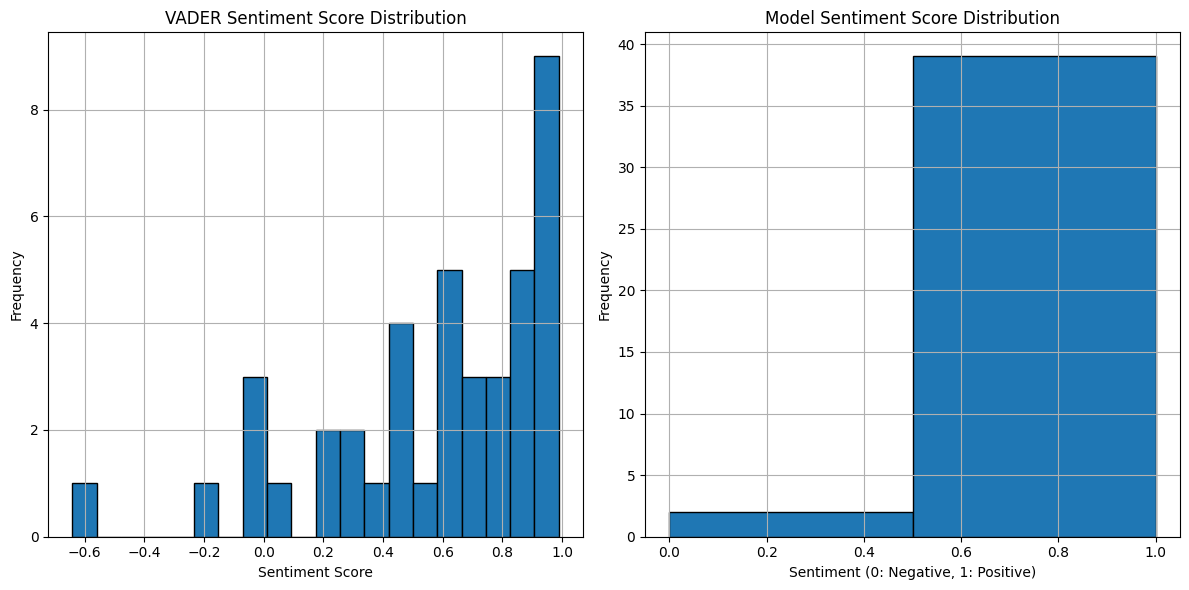

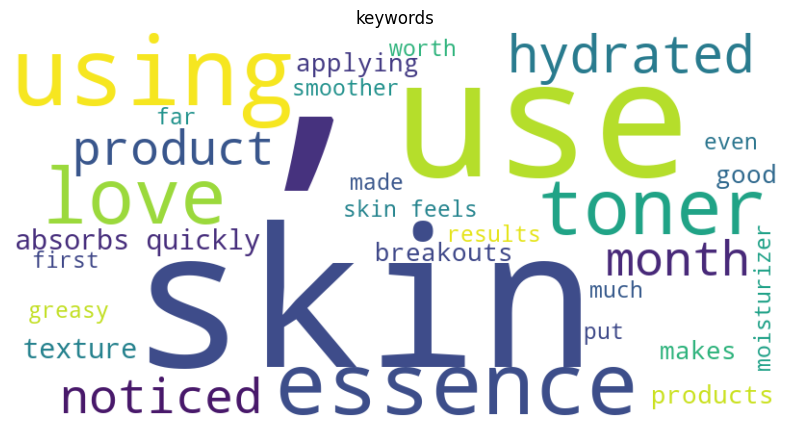

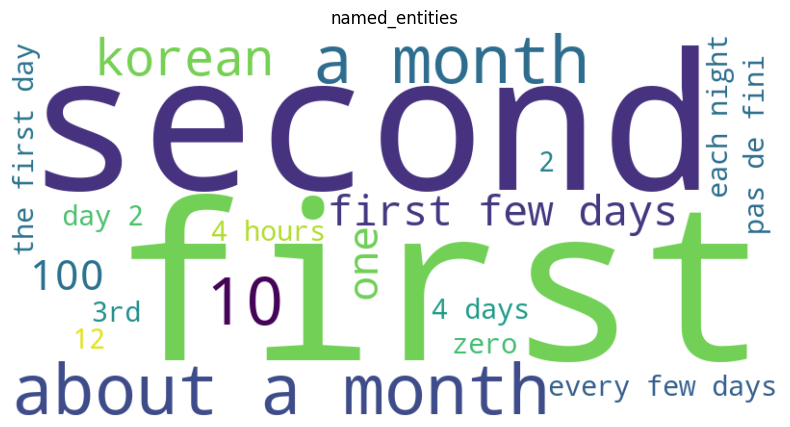

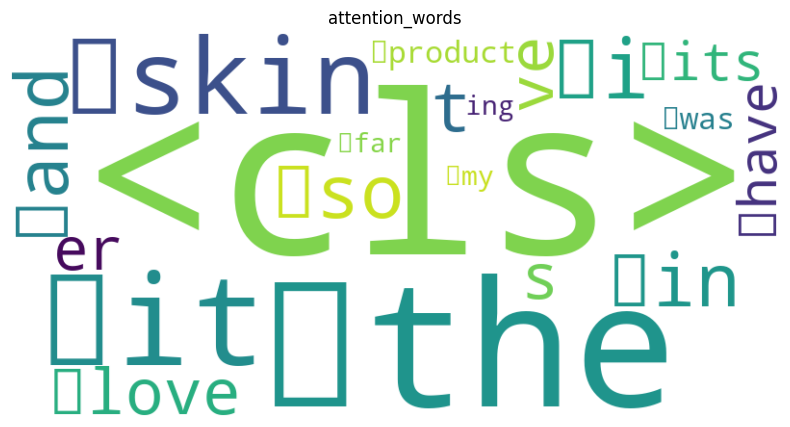

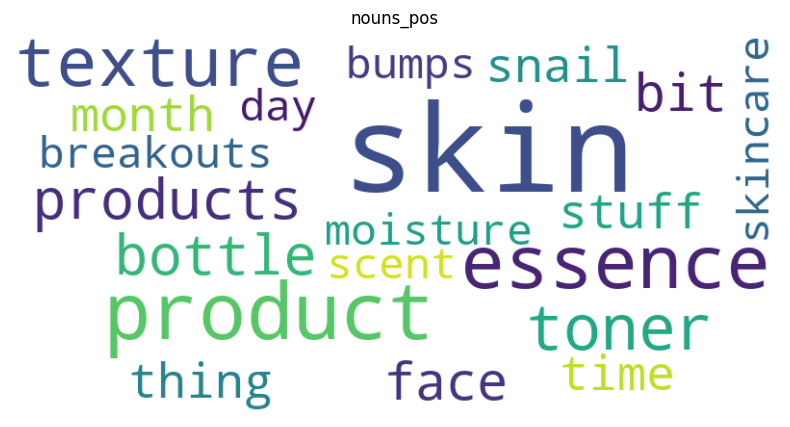

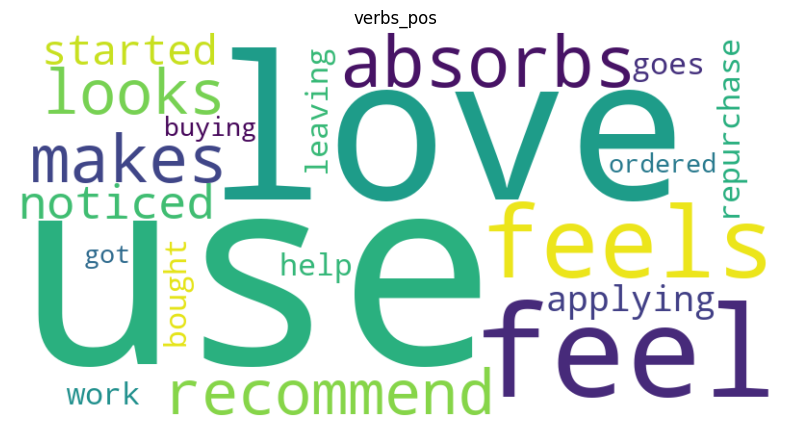

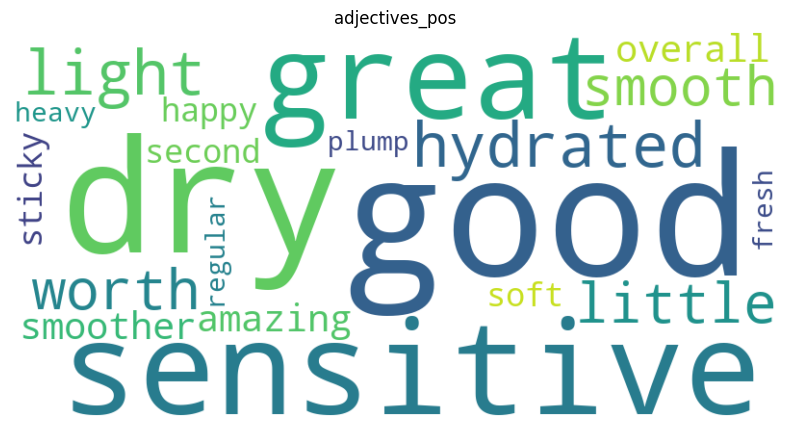

In [23]:
import pandas as pd
# from modules.text_cleaning import clean_text
# from modules.ner import perform_ner
# from modules.pos_tagging import get_pos_tags, top_pos_tags
# from modules.emotion_detection import detect_emotions
# from modules.keyword_extraction import extract_keywords
# from modules.plot_distribution import plot_sentiment_distribution, create_word_cloud
# from pytorch_model.inference import predict_single_text
# from pytorch_model.model import Transformer, text_transform, vocab
import torch
import numpy as np
import matplotlib.pyplot as plt

# Constants
NUM_KEYWORDS = 30
NUM_NER = 20
NUM_ATTENTION_WORDS = 20

def import_and_process_data(file_path):
    df = pd.read_excel(file_path, header=None, names=['review'])
    reviews = df['review'].tolist()
    
    # Clean the entire list of reviews
    cleaned_reviews = [clean_text(review) for review in reviews]
    
    # NER
    entities = perform_ner(cleaned_reviews, NUM_NER)
    
    # POS Tagging
    pos_tags = get_pos_tags(cleaned_reviews)
    top_pos = top_pos_tags(pos_tags)
    
    # Emotion Detection
    vader_scores = detect_emotions(cleaned_reviews)
    
    # Keyword Extraction
    keywords = extract_keywords(cleaned_reviews, NUM_KEYWORDS)
    
    # Compute statistics
    avg_sentiment_score = np.mean(vader_scores)
    avg_word_count = np.mean([len(review.split()) for review in reviews])
    print(f"Average VADER Sentiment Score: {avg_sentiment_score:.2f}")
    print(f"Average Word Count per Review: {avg_word_count:.2f}")
    
    # NER
    print("\nTop Named Entities:")
    for entity, count in entities:
        print(f"{entity[0]} ({entity[1]}): {count}")

    # POS
    print("\nTop POS Tags:")
    for pos in ['nouns', 'verbs', 'adjectives']:
        print(f"\nTop {pos.capitalize()}:")
        for word, count in top_pos[pos]:
            print(f"{word}: {count}")

    # Keyword extraction
    print("\nTop Keywords Extracted:")
    for keyword, count in keywords:
        print(f"{keyword}: {count}")

    # PyTorch Model Inference
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = Transformer()
    model.load_state_dict(torch.load('model_weights/gpt.pth', map_location=device))
    model = model.to(device)
    model.eval()

    print("\nPyTorch Model Predictions:")
    model_predictions = []
    all_top_words = []
    for review in cleaned_reviews:
        prediction, top_words = predict_single_text(model, review, text_transform, vocab)
        model_predictions.append(prediction)
        all_top_words.extend(top_words)

    # Get top attention words
    top_attention_words = Counter(all_top_words).most_common(NUM_ATTENTION_WORDS)
    print("\nTop Attention Words:")
    for word, count in top_attention_words:
        if word not in ['<cls>', '▁the', '▁it', '▁i', '▁in', '▁and', '▁so', 't', 's', 've', 'er', '▁have', '▁its', '▁was', '▁my', 'ing']:
            print(f"{word}: {count}")

    # Calculate average sentiment score from the model
    model_avg_sentiment = sum([1 if pred == 'positive' else 0 for pred in model_predictions]) / len(model_predictions)
    print(f"\nAverage Model Sentiment Score: {model_avg_sentiment:.2f}")

    # Plot sentiment distributions
    plot_sentiment_distribution(vader_scores, model_predictions)

    # Create word clouds
    create_word_cloud(dict(keywords), 'keywords')
    
    # For entities, we need to create a dictionary with entity text as key
    entity_dict = {entity[0]: count for (entity, count) in entities}
    create_word_cloud(entity_dict, 'named_entities')
    
    create_word_cloud(dict(top_attention_words), 'attention_words')
    for pos in ['nouns', 'verbs', 'adjectives']:
        create_word_cloud(dict(top_pos[pos]), f'{pos}_pos')

if __name__ == "__main__":
    file_path = 'sentiment_data/73.xlsx'
    import_and_process_data(file_path)